In [1]:
import pickle
from scipy.stats.mstats import gmean
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df1 = pd.read_stata(fpath + "/full_data_6yrs_no_term_specific.dta")
df2 = pd.read_stata(fpath + "/full_data_truncated_no_term_specific.dta")
df2 = df2[df2.valid == 1]
df = pd.concat([df1,df2]).sort_values(['vccsid'])

In [3]:
for p in ["grants", "sub_loans", 'unsub_loans', 'others']:
    df.loc[:,p] = 0
    for s in ['yr1','yr2','yr3','yr4','yr5','yr6']:
        df.loc[:,p] += df.loc[:,p+"_"+s]
    df.loc[:,p] = df[p]/(df.pct_vccs * df.available)

In [4]:
df = df.drop(['available'], axis=1)

##### **Note: This model variant only includes 60 predictors, which are all non-term-specific predictors

In [5]:
predictors = [p for p in list(df.columns)[10:] if p[-3:] not in ['yr1','yr2','yr3','yr4','yr5','yr6']]
print(len(predictors))
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

60


In [6]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(300144, 94) (33115, 94)


In [7]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test 

In [8]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [10]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [12]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_new_7\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [13]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.889948
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.91183
[100]	validation-auc:0.914874
[150]	validation-auc:0.917381
[200]	validation-auc:0.919802
[250]	validation-auc:0.921883
[300]	validation-auc:0.923454
[350]	validation-auc:0.92481
[400]	validation-auc:0.92595
[450]	validation-auc:0.926972
[500]	validation-auc:0.927799
[550]	validation-auc:0.928509
[600]	validation-auc:0.929047
[650]	validation-auc:0.929557
[700]	validation-auc:0.929964
[750]	validation-auc:0.930329
[800]	validation-auc:0.930723
[850]	validation-auc:0.931042
[900]	validation-auc:0.931378
[950]	validation-auc:0.931659
[1000]	validation-auc:0.931909
[1050]	validation-auc:0.932154
[1100]	validation-auc:0.932376
[1150]	validation-auc:0.932583
[1200]	validation-auc:0.932804
[1250]	validation-auc:0.932983
[1300]	validation-auc:0.93315
[1350]	validation-auc:0.933312
[1400]	validation-auc:0.933479
[1450]	validation-auc:0.933631
[1500]	v

[350]	validation-auc:0.937842
[400]	validation-auc:0.937994
Stopping. Best iteration:
[436]	validation-auc:0.938116


max_depth = 5, eta = 0.2:
[0]	validation-auc:0.900411
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.933763
[100]	validation-auc:0.936243
[150]	validation-auc:0.93705
[200]	validation-auc:0.937507
[250]	validation-auc:0.937652
Stopping. Best iteration:
[276]	validation-auc:0.9377


max_depth = 6, eta = 0.01:
[0]	validation-auc:0.908388
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[12]	validation-auc:0.919958


max_depth = 6, eta = 0.02:
[0]	validation-auc:0.908388
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.923744
[100]	validation-auc:0.927144
[150]	validation-auc:0.929865
[200]	validation-auc:0.93189
[250]	validation-auc:0.933267
[300]	validation-auc:0.934198
[350]	validation-auc:0.934904
[400]	validation-auc:0.935503
[450]	validation-auc:0.935942
[50

In [14]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.02), 0.939455)
((7, 0.01), 0.939253)
((6, 0.05), 0.939032)
((7, 0.05), 0.938934)
((7, 0.1), 0.938922)
((6, 0.02), 0.938699)
((6, 0.1), 0.938514)
((5, 0.05), 0.938371)
((5, 0.02), 0.938228)
((5, 0.1), 0.938116)
((6, 0.2), 0.937896)
((5, 0.2), 0.9377)
((4, 0.1), 0.937508)
((7, 0.2), 0.937373)
((4, 0.02), 0.937106)
((4, 0.05), 0.937033)
((4, 0.2), 0.937007)
((4, 0.01), 0.936935)
((6, 0.01), 0.919958)
((5, 0.01), 0.916131)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [15]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.05, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.900411
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.925466
[100]	validation-auc:0.930875
[150]	validation-auc:0.933087
[200]	validation-auc:0.934417
[250]	validation-auc:0.935221
[300]	validation-auc:0.935925
[350]	validation-auc:0.936444
[400]	validation-auc:0.936834
[450]	validation-auc:0.937143
[500]	validation-auc:0.93741
[550]	validation-auc:0.93762
[600]	validation-auc:0.937816
[650]	validation-auc:0.938029
[700]	validation-auc:0.938121
Stopping. Best iteration:
[713]	validation-auc:0.938165


max_depth = 5, min_child_weight = 5:
[0]	validation-auc:0.900411
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.92547
[100]	validation-auc:0.930925
[150]	validation-auc:0.933125
[200]	validation-auc:0.934482
[250]	validation-auc:0.935301
[300]	validation-auc:0.935974
[350]	validation-auc:0.936438
[400]	validation-auc:0.936774
[450]	validation-auc:0.937101
[50

In [16]:
for t in validation_auc_2.most_common():
    print(t)

((7, 3), 0.939395)
((7, 5), 0.939087)
((6, 3), 0.93898)
((6, 5), 0.938595)
((5, 5), 0.938249)
((5, 3), 0.938165)


#### (3) Grid Search for colsample_by_tree

In [17]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 3, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.910023
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.930422
[100]	validation-auc:0.934654
[150]	validation-auc:0.936482
[200]	validation-auc:0.937625
[250]	validation-auc:0.938225
[300]	validation-auc:0.938721
[350]	validation-auc:0.938933
[400]	validation-auc:0.93914
Stopping. Best iteration:
[436]	validation-auc:0.939263


colsample_by_tree = 0.55:
[0]	validation-auc:0.910277
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.93065
[100]	validation-auc:0.934809
[150]	validation-auc:0.936488
[200]	validation-auc:0.937598
[250]	validation-auc:0.93811
[300]	validation-auc:0.938556
[350]	validation-auc:0.93876
[400]	validation-auc:0.938914
[450]	validation-auc:0.939093
[500]	validation-auc:0.939347
Stopping. Best iteration:
[530]	validation-auc:0.939445


colsample_by_tree = 0.6:
[0]	validation-auc:0.911234
Will train until validation-auc hasn't improved in 10 rounds.
[50]

In [18]:
validation_auc_3.most_common()

[(0.55, 0.939445),
 (0.8, 0.939395),
 (0.5, 0.939263),
 (0.65, 0.939242),
 (0.7, 0.939175),
 (0.6, 0.939052),
 (0.75, 0.938999),
 (0.9, 0.938902),
 (0.85, 0.938588)]

#### (4) Finally select the opitmal num_boost_round

In [19]:
params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 3, 'colsample_bytree': 0.55, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.910277
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.93065
[100]	validation-auc:0.934809
[150]	validation-auc:0.936488
[200]	validation-auc:0.937598
[250]	validation-auc:0.93811
[300]	validation-auc:0.938556
[350]	validation-auc:0.93876
[400]	validation-auc:0.938914
[450]	validation-auc:0.939093
[500]	validation-auc:0.939347
Stopping. Best iteration:
[530]	validation-auc:0.939445


530


#### (5) Train the final xgb model and make predictions for observations in the test set

In [21]:
optimal_num_boost_round = 530

In [22]:
# specify parameters via map
params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 3, 'colsample_bytree': 0.55, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [23]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.8504


In [24]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "/xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "/y_test_pred_xgb.p", "wb"))

In [25]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

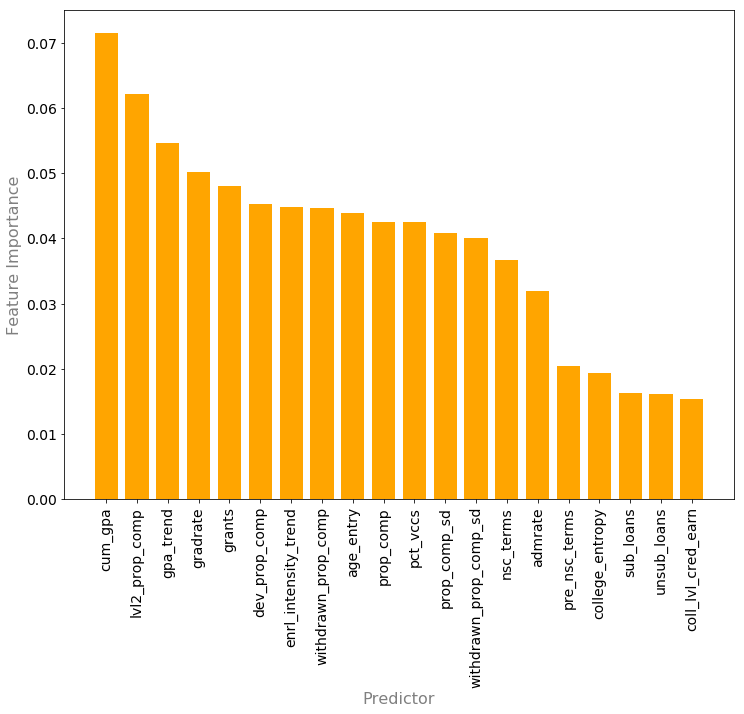

In [27]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png")
plt.show()

In [28]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [29]:
final_params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 3, 'colsample_bytree': 0.55, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.9396704068078309 0.0008349082230579976


In [30]:
best_threshold

0.39408845

In [32]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [33]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.394:

         Pred_0   Pred_1         
Real_0  16563.0   5245.0  21808.0
Real_1   2452.0   8855.0  11307.0
        19015.0  14100.0  33115.0

F1 score = 0.6971


In [34]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.491:

         Pred_0   Pred_1         
Real_0  18205.0   3603.0  21808.0
Real_1   3438.0   7869.0  11307.0
        21643.0  11472.0  33115.0

F1 score = 0.6909


In [35]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the four non-truncated models: OLS, Logit, RF, XGBoost

In [10]:
# Extract all of the key evaluation metrics of the four non-truncated models that only include simple non-term-specific predictors,
# which will be used to populate column (4) within the Appendix Table A1 and Figure 1 of the paper
cstat = [0.8467,0.8441,0.8780,0.8885]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost'}
m_list = ['Logit', 'OLS', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.round(4).to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)